# LSTM

In [4]:
import Pkg; #Pkg.add("IterTools"); Pkg.add("Knet"); Pkg.add("Plots"); Pkg.add("CUDA"); Pkg.add("PlotlyJS")
using Knet
using Printf
using Statistics: mean
using Base.Iterators: flatten
using IterTools: ncycle, takenth
import .Iterators: cycle, Cycle, take
using Plots; plotlyjs()
using DelimitedFiles, Statistics, Random
import CUDA
import LinearAlgebra
import Plots: heatmap
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
dataset_directory_path = "../DATA"
dataset_directory = filter(x -> isdir(joinpath(dataset_directory_path, x)), readdir(dataset_directory_path))

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-9250306317419645803\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-8495854849634131580\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-9250306317419645803\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

7-element Array{String,1}:
 "doganay_experiment"
 "idil_experiment"
 "istenc_experiment"
 "omer_experiment"
 "ozan_experiment"
 "yahya_experiment"
 "zaid_experiment"

In [5]:
send_message(message) = run(`curl https://notify.run/zrqfxE0M1ypL5Dv4 -d $message`);

In [6]:
function split_and_convert(string_array,splitter)
    Rlength = length(string_array)
    Clength = length(split(string_array[1],splitter))
    Mdata = zeros(Float64,Rlength,Clength)
    for i in 1:Rlength
        row =  map(x->tryparse(Float64,x),split(string_array[i],splitter))
        Mdata[i,:] = row
    end
    return Mdata
end

split_and_convert (generic function with 1 method)

In [7]:
time_history = 50;

In [8]:
function data_selection(participant_directory_path)
    data_matrix = Array{Float32}(undef,0,9);
    participant_directory = readdir(participant_directory_path)
    for raw_txt_files in participant_directory
            txt_file_directory_path = joinpath(participant_directory_path, raw_txt_files)
            txt_file_directory = readdir(txt_file_directory_path)
            
            raw_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[4]))
            raw_data = split_and_convert(readlines(raw_data_file),",")
            close(raw_data_file)
            
            #To avoiding the colliding between subtask 3 and subtask 1
            _, remain = divrem(size(raw_data,1),time_history)
            
            #  Velocity F_fint  F_h  subtask 
            #  1        2       3      4     
            data_matrix = [data_matrix; raw_data[1:end-remain,:]]
        end
        
    return data_matrix
end

data_selection (generic function with 1 method)

In [9]:
test_data = Array{Float32}(undef,0,9);
train_data = Array{Float32}(undef,0,9);

for participant_index in 1:length(dataset_directory)
    #Participants: 1.doganay 2.idil 3.istenc 4.omer 5.ozan 6.yahya 7.zaid
    participant_directory_path = joinpath(dataset_directory_path,dataset_directory[participant_index])
    participant_directory = readdir(participant_directory_path)
    
    if participant_index != 5
        data = data_selection(participant_directory_path)
        train_data = [train_data;data]
    else
        data = data_selection(participant_directory_path)
        test_data = [test_data;data]
    end
end

Sorting by Length (Descending)

In [7]:
#max_, _ = findmax(list_series)
#min_ , _ = findmin(list_series)
#mean_ = mean(list_series)
#print("Max: ",max_," Min: ", min_ ," Mean: ", mean_)
# Adding Related Time Series Length to the DATA
#assign_durations(data_array,duration_list) = for i in 1:size(data_array)[1]; data_array[i] = [data_array[i],duration_list[i]];end
##For the train_data
#assign_durations(train_data,list_series[1:length(train_data)])
##For the test_data
#assign_durations(test_data,list_series[length(train_data)+1:end])
# Sorting Data
#sort!(train_data, by = x -> x[:][2],rev=true); 
#sort!(test_data, by = x -> x[:][2],rev=true); 

In [10]:
mutable struct pHRIHelper
   measurements
   subtasks
   batchsize
   time_history
   ninstances
   shuffled
end

function data_splitter(raw_data)
    input = [raw_data[:,2] raw_data[:,3] raw_data[:,5]];
    output = raw_data[:,end];
    return input,output
end


function pHRIHelper(raw_data; batchsize = 128, time_history = 50, shuffled = true)
   measurements, subtasks = data_splitter(raw_data)
   measurement_pocket = []
   subtask_pocket = []
   needed_volume = time_history+batchsize-1;
   counter = 1;
   measurement_instance = [];
   subtask_instance = [];
   length_instance = 0;
   for i in 1:size(measurements,1)
        if counter <= needed_volume
            push!(measurement_instance,measurements[i,:])
            push!(subtask_instance,subtasks[i])
        else
           counter = 0;
           push!(measurement_pocket,measurement_instance)
           push!(subtask_pocket,subtask_instance)
           measurement_instance = [];
           subtask_instance = []; 
           length_instance +=1;
        end
        counter +=1;
   end
    if length(measurement_instance) > 1
       push!(measurement_pocket,measurement_instance)
       push!(subtask_pocket,subtask_instance) 
    end
   #ninstances, _ = divrem(length(subtasks),needed_volume)
   #ninstances = convert(Int,ninstances)
    #if length_instance == ninstances
    #    display("It Works")
    #else
    #    display(length_instance)
    #    display(ninstances)
    #end

   return pHRIHelper(measurement_pocket,subtask_pocket,batchsize,time_history,length_instance,shuffled)
end

pHRIHelper

In [11]:
#State data stands for ninstances, But every iteration it gets 50 timesteps for each batchsize element.
#Each element 
function Base.iterate(d::pHRIHelper, state=ifelse(d.shuffled, randperm(d.ninstances), 1:d.ninstances))
    length(state) < 1  && return nothing
    output = KnetArray(zeros(Int32,d.batchsize,d.time_history));            # time_steps,1
    input  = KnetArray(zeros(Float32,3,d.batchsize,d.time_history));        # X B T -> 3x16x50
    needed_volume = d.batchsize+d.time_history-2;
    raw_measurement = d.measurements[state[1]]
    size(raw_measurement,1) < needed_volume && return nothing
    related_measurements = KnetArray(zeros(Float32,size(raw_measurement,1),3))
    for i = 1:size(raw_measurement,1)
       related_measurements[i,:] = (KnetArray(raw_measurement[i]')) 
    end

    related_subtasks = convert(Array{Int32,1},d.subtasks[state[1]]);
    
    buffer = zeros(time_history,1);
    x_matrix = zeros(3,time_history);
    y_matrix = zeros(1,time_history);
    counter = 0;
    for time_step in 1:d.batchsize
        buffer = time_step:time_step+time_history-1;
        x_matrix = related_measurements[buffer,:];
        y_matrix = related_subtasks[buffer];
        input[:,time_step,:] = x_matrix';
        output[time_step,:] = y_matrix;
    end
    new_state = state[2:end]
    
    return ((input, output),new_state)    
end

In [14]:
mutable struct Linear
    w # weight
    b # bias

    function Linear(inputsize, outputsize; atype=array_type, scale::Float64=0.01)
        new(Param(convert(atype,randn(outputsize,inputsize)*scale)),Param(convert(atype,zeros(outputsize,1))))
    end
end

function (l::Linear)(x)
    return l.w*x.+l.b;
end

mutable struct Hidden
    w # weight
    b # bias
    fun # non-linear activation function like relu or tanh

    function Hidden(inputsize, outputsize, fun=relu, atype=array_type, scale=0.1)
        w = Param(convert(atype,randn(outputsize,inputsize)*scale));
        b = Param(convert(atype,zeros(outputsize,1)));
         new(w,b,fun)
    end
end

function (l::Hidden)(x)
    return l.fun.(l.w*x.+l.b);
end

In [15]:
mutable struct pHRITrainer
    hidden_input::Hidden
    rnn::RNN
    hidden::Linear
end

function pHRITrainer(input_size, hidden_size, output_size, atype=array_type)
    hidden_input = Hidden(input_size,hidden_size)
    rnn = RNN(hidden_size,hidden_size; numLayers=3,rnnType=:lstm);
    hidden = Linear(hidden_size,output_size)
    return pHRITrainer(hidden_input,rnn, hidden)
end 

function (m::pHRITrainer)(x)
    dim = size(x)
    a = m.hidden_input(reshape(x,size(x,1),:))
    b = m.rnn(reshape(a,size(a,1),dim[2],dim[3]));
    c = m.hidden(reshape(b,size(b,1),:));
    output = reshape(c,size(c,1),dim[2],dim[3]);
    return output;
end

function(m::pHRITrainer)(x,y)
    nll(model(x),y;average=true)
end

function (m::pHRITrainer)(data::pHRIHelper)
    total_loss = 0
    count = 0
    for (x,y) in data
        (loss,number) = nll(model(x),y;average=false)
        total_loss += loss
        count += number
    end
    return total_loss/count
end

In [52]:
function loss(model::pHRITrainer, data; average=true)
    total_loss = 0
    count = 0
    for (x,y) in data
        (loss,number) = nll(model(x),y;average=false)
        total_loss += loss
        count += number
    end
    average && return total_loss/count
    return total_loss, count
end

function confusions(model::pHRITrainer, data)
    ntokens = 0; ncorrect = 0
    total_ygold = Int[] ; total_ypred = Int[];
    subtasks = [1,2,3]
    for (x, ygold) in data
        scores = model(x)
        ntokens += length(ygold)
        ypred = map( y -> y[1], argmax(scores, dims=1))
        ypred = Array{Int64}(reshape(ypred,size(ypred,2),size(ypred,3)))
        ygold = Array{Int64}(ygold)
        total_ygold = [total_ygold;ygold[data.batchsize,:]]
        total_ygold = [total_ygold;ygold[1:data.batchsize-1,data.time_history]]
        total_ypred = [total_ypred;ypred[data.batchsize,:]]
        total_ypred = [total_ypred;ypred[1:data.batchsize-1,data.time_history]]
        ncorrect += sum(ygold .== ypred)
    end
        if 0 in total_ygold
            display("oa")
        end

        a = confusion_matrix(total_ygold,total_ypred, labels = subtasks)
        
        display(f1_score(a))
        display(a)
    return ncorrect / ntokens
end


confusions (generic function with 1 method)

In [17]:
function train_custom!(model, trn, dev,train_raw)
    train_loss, test_loss = Any[],Any[]
    #train_loss = [train_loss; loss(model, train_raw)];
    #test_loss = [test_loss; loss(model,dev)];
    #display(size(test_loss))
    train_error = Array{Float64,1}()
    test_error = Array{Float64,1}()
    
    bestmodel, bestloss = deepcopy(model), loss(model,dev)#test_loss[1]
    progress!(adam(model, trn), steps=2671) do y 
        test_losses = loss(model,dev)
        train_losses = loss(model, train_raw)
        train_loss = [train_loss; train_losses]
        test_loss = [test_loss; test_losses]
        push!(train_error, 1-accuracy(model,data = train_raw))
        push!(test_error, 1 -accuracy(model,data=dev))
        #display(size(test_loss))
        if test_losses < bestloss
            bestmodel, bestloss = deepcopy(model), test_losses
        end
        return (test_losses)
    end
    return bestmodel,train_loss,test_loss,train_error,test_error
end

train_custom! (generic function with 1 method)

In [258]:
Random.seed!(1)
dtrn = pHRIHelper(train_data;shuffled=true);
dtst = pHRIHelper(test_data;shuffled=true);
model = pHRITrainer(3, 128, 3)

ctrn = []; epochs=40;
for b in dtrn
   push!(ctrn,b) 
end

trnx10 = collect(flatten(ctrn for i in 1:epochs));


dtrn = pHRIHelper(Any[Any[[0.0, -6.8896e-5, -0.006846], [0.0, -0.00031239, 0.00050694], [0.0, -0.00073963, 0.0036133], [0.0, -0.0012885, -0.0074269], [0.0, -0.0019064, -0.00040893], [0.0, -0.0025651, -0.007364], [0.0, -0.0032447, -0.015244], [0.0, -0.0039277, -0.010941], [0.0, -0.0045788, 0.0017111], [0.0, -0.005128, 0.010278], [0.0, -0.0054956, 0.0083347], [0.0, -0.0056473, 0.004604], [0.0, -0.0056183, -0.014318], [0.0, -0.0054823, -0.0059335], [0.0, -0.0053052, -0.0063219], [0.0, -0.0051, 0.0043814], [0.0, -0.0048299, 0.0034634], [0.0, -0.004472, 0.0032412], [0.0, -0.0040596, -0.0020851], [0.0, -0.0036715, -0.01157], [0.0, -0.0033923, -0.0063511], [0.0, -0.0032624, 0.0010606], [0.0, -0.0032503, 0.00027297], [0.0, -0.0032954, 0.01077], [0.0, -0.0033458, 0.0069123], [0.0, -0.0033794, -0.0028076], [0.0, -0.0034156, -0.0035895], [0.0, -0.0034701, -0.004565], [0.0, -0.0035096, 0.0064775], [0.0, -0.0034551, 0.0062226], [0.0, -0.0032385, 0.0077566], [0.0, -0.0028496, 0.00025332], [0.0, -0.0

000284, 1.1913, 2.0827], [0.0002864, 1.2266, 2.117], [0.0002888, 1.2632, 2.1535], [0.000292, 1.3016, 2.1348], [0.0002952, 1.3415, 2.2565], [0.0003, 1.3828, 2.3196], [0.000304, 1.4247, 2.3568], [0.0003096, 1.4666, 2.4115], [0.0003144, 1.5079, 2.4618], [0.0003208, 1.5483, 2.4965], [0.0003264, 1.5872, 2.5111], [0.000332, 1.6247, 2.5738], [0.00034, 1.6611, 2.6152], [0.0003472, 1.6966, 2.5453], [0.000356, 1.7316, 2.6021], [0.0003648, 1.7666, 2.665], [0.0003736, 1.8024, 2.7029]], Any[[0.0003936, 1.8786, 2.8577], [0.0004032, 1.9192, 2.9578], [0.0004136, 1.9616, 3.128], [0.0004248, 2.0057, 3.3245], [0.0004368, 2.0512, 3.5021], [0.0004488, 2.0979, 3.5635], [0.0004608, 2.1454, 3.7731], [0.0004736, 2.1937, 3.9807], [0.0004864, 2.2429, 4.1035], [0.0005, 2.2929, 4.1761], [0.0005128, 2.3441, 4.2927], [0.0005264, 2.3968, 4.4087], [0.00054, 2.4518, 4.5709], [0.0005544, 2.5095, 4.6863], [0.0005688, 2.5704, 4.8726], [0.000584, 2.6348, 4.9973], [0.0005992, 2.7027, 5.097], [0.0006152, 2.7742, 5.323], [0.0

.013333, 29.705, 29.289], [0.013329, 29.695, 29.262], [0.013325, 29.685, 29.265], [0.013322, 29.674, 29.195], [0.013318, 29.663, 29.273], [0.013314, 29.652, 29.384], [0.01331, 29.642, 29.485], [0.013306, 29.634, 29.572], [0.013301, 29.627, 29.599], [0.013297, 29.622, 29.626], [0.013292, 29.619, 29.628], [0.013288, 29.618, 29.592], [0.013283, 29.618, 29.595], [0.01328, 29.619, 29.503], [0.013276, 29.62, 29.43], [0.013271, 29.62, 29.405], [0.013267, 29.619, 29.352], [0.013262, 29.616, 29.352], [0.013259, 29.611, 29.243], [0.013254, 29.604, 29.189], [0.01325, 29.595, 29.19], [0.013246, 29.584, 29.203], [0.013242, 29.573, 29.261], [0.013238, 29.562, 29.239], [0.013234, 29.551, 29.142], [0.01323, 29.541, 29.146], [0.013226, 29.532, 29.119], [0.013221, 29.523, 29.105], [0.013217, 29.515, 29.059], [0.013214, 29.506, 28.994], [0.01321, 29.498, 29.054], [0.013206, 29.489, 29.082], [0.013202, 29.48, 29.171], [0.013199, 29.471, 29.169], [0.013196, 29.461, 29.094], [0.013193, 29.451, 29.068], [0.0

 1.3209, 24.709], [0.0009888, 1.3359, 23.883], [0.0009712, 1.3503, 22.922], [0.0009536, 1.361, 21.841], [0.000936, 1.3664, 21.15], [0.0009192, 1.3665, 20.684], [0.000904, 1.3613, 20.866], [0.0008888, 1.3499, 21.348], [0.0008728, 1.3327, 21.723], [0.0008592, 1.311, 22.544], [0.0008456, 1.2871, 23.52], [0.0008312, 1.2645, 24.639], [0.0008184, 1.2469, 25.965], [0.0008048, 1.2382, 26.286], [0.000792, 1.2411, 26.451], [0.00078, 1.2574, 26.676], [0.0007672, 1.2878, 26.675], [0.000756, 1.3291, 25.879], [0.000744, 1.3746, 24.922], [0.0007328, 1.4187, 23.871], [0.0007216, 1.4588, 22.789], [0.000712, 1.493, 22.008], [0.0007032, 1.5196, 21.262], [0.0006936, 1.5383, 20.738], [0.0006848, 1.5499, 20.942], [0.0006776, 1.5553, 21.46], [0.0006696, 1.5551, 22.027], [0.0006624, 1.5498, 22.797], [0.0006568, 1.5406, 23.682], [0.000652, 1.5296, 24.534], [0.0006464, 1.5214, 25.628], [0.0006416, 1.5211, 26.328], [0.0006376, 1.5318, 26.523], [0.0006344, 1.5542, 26.642], [0.0006304, 1.5877, 26.782], [0.0006272,

.05381], [1.9896e-23, 0.0093765, -0.054455], [1.9896e-23, 0.01228, -0.036666], [1.9896e-23, 0.01405, 0.0076737], [1.9896e-23, 0.014413, 0.017062], [1.9896e-23, 0.013371, -0.016164], [1.9896e-23, 0.011101, -0.077192], [1.9896e-23, 0.0079016, -0.026432], [1.9896e-23, 0.0040903, 0.0032078], [1.9896e-23, 0.00022411, 0.021481], [1.9896e-23, -0.0030574, 0.042524], [1.9896e-23, -0.0054201, -0.0070786], [1.9896e-23, -0.0067458, 0.027161], [1.9896e-23, -0.0069911, 0.085358], [1.9896e-23, -0.0061548, 0.067899], [1.9896e-23, -0.0043952, 0.064837], [1.9896e-23, -0.0022005, 0.0038259], [1.9896e-23, -0.00015883, -0.070208], [1.9896e-23, 0.0012526, -0.019513], [1.9896e-23, 0.0016644, -0.02232], [1.9896e-23, 0.00094579, -0.028709], [1.9896e-23, -0.00080214, -0.070894], [1.9896e-23, -0.0032982, -0.051667], [1.9896e-23, -0.0061135, -0.029056], [1.9896e-23, -0.0088745, 0.024486], [1.9896e-23, -0.011209, 0.045232], [1.9896e-23, -0.012761, 0.0010856], [1.9896e-23, -0.01339, -0.010447], [1.9896e-23, -0.0131

 [0.01337, 30.135, 29.606], [0.013369, 30.132, 29.607], [0.01337, 30.128, 29.619], [0.01337, 30.123, 29.548], [0.01337, 30.117, 29.483], [0.013369, 30.11, 29.517], [0.01337, 30.103, 29.505], [0.01337, 30.096, 29.512], [0.01337, 30.088, 29.495], [0.013372, 30.079, 29.424], [0.013373, 30.071, 29.442], [0.013374, 30.062, 29.422], [0.013374, 30.053, 29.488], [0.013375, 30.043, 29.454], [0.013376, 30.032, 29.374], [0.013377, 30.02, 29.391], [0.013377, 30.006, 29.374], [0.013378, 29.992, 29.323], [0.013378, 29.977, 29.319], [0.013378, 29.96, 29.141], [0.013378, 29.943, 29.096], [0.013379, 29.925, 29.106], [0.01338, 29.905, 29.126], [0.01338, 29.885, 29.076], [0.013379, 29.865, 28.994], [0.013378, 29.844, 28.966], [0.013378, 29.822, 29.022], [0.013378, 29.8, 28.994], [0.013377, 29.777, 29.034], [0.013375, 29.754, 29.016], [0.013375, 29.731, 28.989], [0.013374, 29.707, 29.064], [0.013372, 29.684, 29.134], [0.01337, 29.662, 29.214], [0.013366, 29.64, 29.161], [0.013364, 29.62, 29.216], [0.01336

529], [0.0088424, 19.936, 19.531], [0.0088424, 19.936, 19.461], [0.008844, 19.936, 19.409], [0.008844, 19.934, 19.418], [0.008844, 19.93, 19.387], [0.0088448, 19.926, 19.381], [0.0088456, 19.919, 19.399], [0.0088456, 19.912, 19.38], [0.0088464, 19.904, 19.448], [0.0088472, 19.896, 19.513], [0.0088472, 19.889, 19.612], [0.008848, 19.881, 19.632], [0.0088488, 19.875, 19.621], [0.0088488, 19.869, 19.657], [0.0088496, 19.864, 19.736], [0.0088504, 19.861, 19.833], [0.0088504, 19.86, 19.859], [0.0088496, 19.86, 19.779], [0.0088504, 19.862, 19.822], [0.0088504, 19.866, 19.847], [0.0088496, 19.871, 19.913], [0.0088504, 19.879, 19.95], [0.0088504, 19.887, 19.861], [0.0088496, 19.897, 19.824], [0.0088488, 19.907, 19.895]], Any[[0.0088496, 19.925, 19.823], [0.0088488, 19.932, 19.678], [0.0088496, 19.938, 19.602], [0.0088496, 19.941, 19.629], [0.0088488, 19.942, 19.56], [0.008848, 19.941, 19.545], [0.008848, 19.939, 19.451], [0.0088472, 19.937, 19.448], [0.0088464, 19.934, 19.491], [0.0088472, 19.

Excessive output truncated after 524295 bytes.

pHRIHelper(Any[Any[[0.0, -6.8896e-5, -0.006846], [0.0, -0.00031239, 0.00050694], [0.0, -0.00073963, 0.0036133], [0.0, -0.0012885, -0.0074269], [0.0, -0.0019064, -0.00040893], [0.0, -0.0025651, -0.007364], [0.0, -0.0032447, -0.015244], [0.0, -0.0039277, -0.010941], [0.0, -0.0045788, 0.0017111], [0.0, -0.005128, 0.010278]  …  [0.0, -0.0038791, -0.0014413], [0.0, -0.0043374, -0.0034605], [0.0, -0.0048458, 0.0043556], [0.0, -0.0053104, -0.00015764], [0.0, -0.0056543, 0.0018327], [0.0, -0.0058286, 0.0019965], [0.0, -0.0058105, -0.0018703], [0.0, -0.0055907, -0.0049557], [0.0, -0.0051685, 0.0038656], [0.0, -0.0045523, 0.0016546]], Any[[0.0, -0.0028632, -0.0012096], [0.0, -0.0019078, 0.0015533], [0.0, -0.00098591, -0.0044986], [0.0, -0.00017657, -0.0019877], [0.0, 0.00045933, -3.8758e-5], [0.0, 0.00089042, -0.0035873], [0.0, 0.0011219, 0.005313], [0.0, 0.0011577, 0.0012789], [0.0, 0.00099456, -0.0063], [0.0, 0.00071173, -0.001061]  …  [1.9896e-23, 0.00042229, 0.0062543], [1.9896e-23, 0.000665

┣████████████████████┫ [100.00%, 107360/107360, 25:21/25:21, 70.57i/s] 5.966584e-12


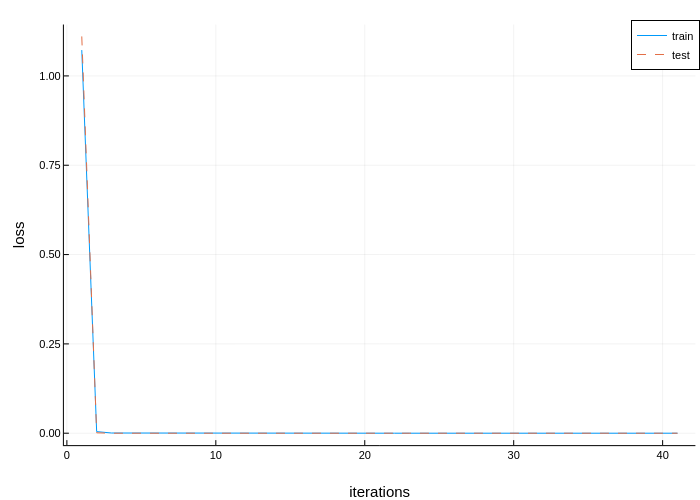

In [68]:
model,trnloss,tstloss = train!(model, trnx10, dtst,dtrn)

default(fmt=:png,ls=:auto)
plot(1:length(trnloss), trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(1:length(tstloss), tstloss, label="test")

#display(model(dtrn))
#display(nll(model;data=dtrn))

In [71]:
dloss = loss(model, dtst)
tloss = loss(model, dtrn)
dacc = accuracy(model, dtst)
tacc = accuracy(model, dtrn)

println("Development loss = ", dloss)
println("Development accuracy = ", dacc)
println("Training loss = ", tloss)
println("Training accuracy = ", tacc)

Development loss = 0.0
Development accuracy = 1.0
Training loss = 5.05984e-5
Training accuracy = 0.9999850968703428


"Model Created"

"training Started"

┣████████████████████┫ [100.00%, 106200/106200, 01:24:32/01:24:32, 20.94i/s] 0.07309179


"training Done"

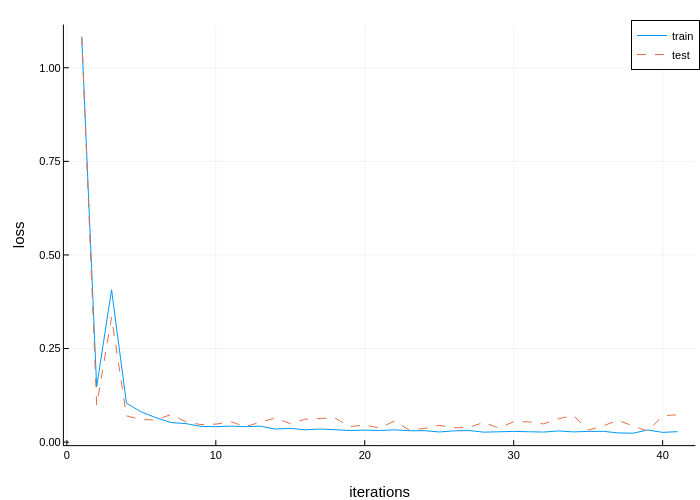

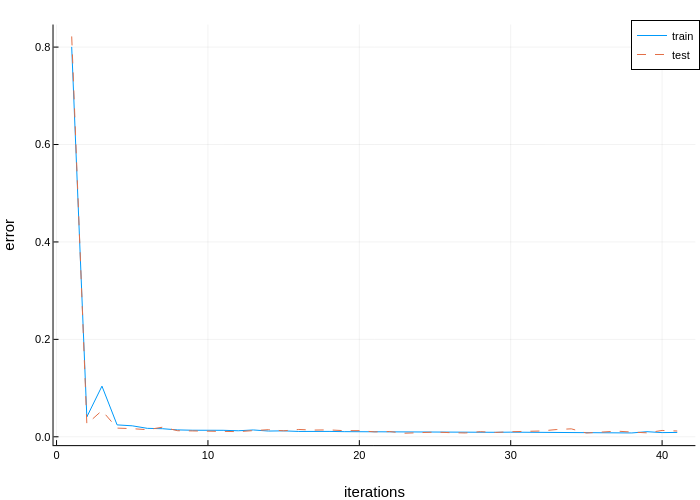

"Last Results"

Development loss = 0.029370224
Development accuracy = 0.9918805108921162
Training loss = 0.03235759
Training accuracy = 0.9895374882297552


In [28]:
Random.seed!(1)
dtrn = pHRIHelper(train_data;shuffled=true);
dtst = pHRIHelper(test_data;shuffled=true);
model = pHRITrainer(3, 128, 3)
display("Model Created")
ctrn = []; epochs=40;
for b in dtrn
   push!(ctrn,b) 
end
trnx10 = collect(flatten(ctrn for i in 1:epochs));
display("training Started")
model_trained,trnloss,tstloss,trnerror,tsterror = train_custom!(model, trnx10, dtst,dtrn)
display("training Done")
default(fmt=:png,ls=:auto)
loss_graph = plot(1:41, trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(1:41, tstloss, label="test")
error_graph = plot(1:41, trnerror, label="train", xlabel="iterations", ylabel="error")
plot!(1:41, tsterror, label="test")
display(loss_graph)
display(error_graph)

display("Last Results")
dloss = loss(model_trained, dtst)
tloss = loss(model_trained, dtrn)
dacc = accuracy(model_trained, dtst)
tacc = accuracy(model_trained, dtrn)

println("Development loss = ", dloss)
println("Development accuracy = ", dacc)
println("Training loss = ", tloss)
println("Training accuracy = ", tacc)

In [53]:
confusions(model, dtst)

3-element Array{Float64,1}:
 0.9870466911011451
 0.9881204964996976
 0.9797515272153202

            Expected

      1      2      3
_____________________
  21679    353      0   │1 
    216  48202     23   │2 
      0    567  14274   │3	Predicted


0.9881292142116183

In [30]:
dloss = loss(model, dtst)
tloss = loss(model, dtrn)
dacc = accuracy(model, dtst)
tacc = accuracy(model, dtrn)

println("Development loss = ", dloss)
println("Development accuracy = ", dacc)
println("Training loss = ", tloss)
println("Training accuracy = ", tacc)

Development loss = 0.07309179
Development accuracy = 0.9881292142116183
Training loss = 0.027983489
Training accuracy = 0.9910471986817326


"Model Created"

"training Started"

┌ Warning: nll(scores, answers::KnetArray{Int32,2} is inefficient, nll(scores, answers::Array{<:Integer}) is better.
└ @ Knet.Ops20_gpu /kuacc/users/berkguler20/.julia/packages/Knet/OYNCT/src/ops20_gpu/loss.jl:8
┌ Warning: accuracy(scores, answers::KnetArray{Int32,2} is inefficient, nll(scores, answers::Array{<:Integer}) is better.
└ @ Knet.Ops20_gpu /kuacc/users/berkguler20/.julia/packages/Knet/OYNCT/src/ops20_gpu/loss.jl:13
┣████████████████████┫ [100.00%, 7965/7965, 08:04/08:04, 16.44i/s] 0.08339807


"training Done"

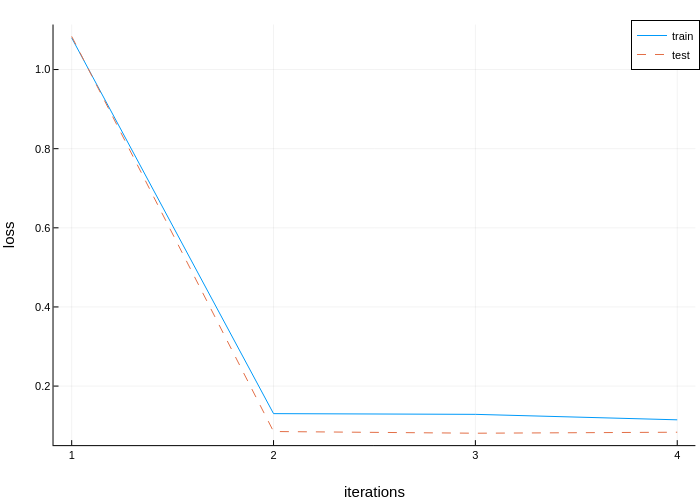

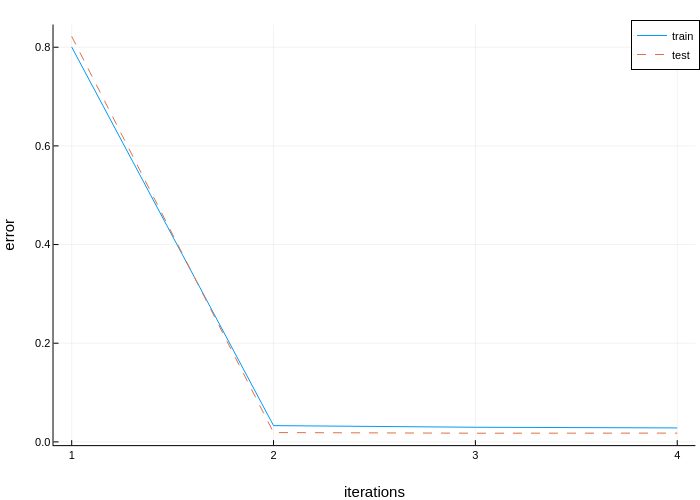

"Last Results"

┌ Warning: accuracy(model,data; o...) is deprecated, please use accuracy(model; data=data, o...)
└ @ Knet.Ops20 /kuacc/users/berkguler20/.julia/packages/Knet/OYNCT/src/ops20/loss.jl:205


Development loss = 0.0808686
Development accuracy = 0.9824539678423236
Training loss = 0.12856832
Training accuracy = 0.9703555790960452


In [18]:
Random.seed!(1)
dtrn = pHRIHelper(train_data;shuffled=true);
dtst = pHRIHelper(test_data;shuffled=true);
model = pHRITrainer(3, 128, 3)
display("Model Created")
ctrn = []; epochs=3;
for b in dtrn
   push!(ctrn,b) 
end
trnx10 = collect(flatten(ctrn for i in 1:epochs));
display("training Started")
model_trained,trnloss,tstloss,trnerror,tsterror = train_custom!(model, trnx10, dtst,dtrn)
display("training Done")
default(fmt=:png,ls=:auto)
loss_graph = plot(1:4, trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(1:4, tstloss, label="test")
error_graph = plot(1:4, trnerror, label="train", xlabel="iterations", ylabel="error")
plot!(1:4, tsterror, label="test")
display(loss_graph)
display(error_graph)

display("Last Results")
dloss = loss(model_trained, dtst)
tloss = loss(model_trained, dtrn)
dacc = accuracy(model_trained, dtst)
tacc = accuracy(model_trained, dtrn)

println("Development loss = ", dloss)
println("Development accuracy = ", dacc)
println("Training loss = ", tloss)
println("Training accuracy = ", tacc)

"Model Created"

"training Started"

┣████████████████████┫ [100.00%, 13350/13350, 16:42/16:42, 13.32i/s] 0.10547353


"training Done"

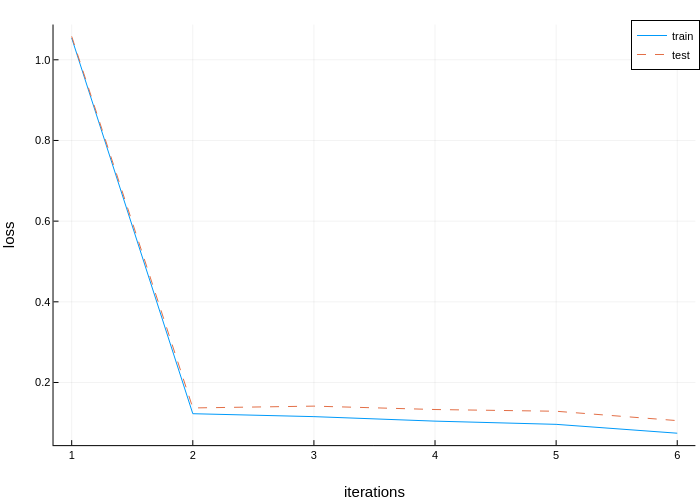

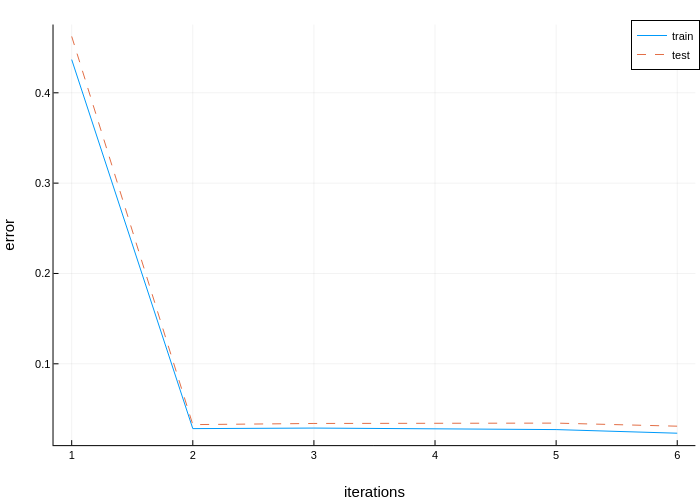

"Last Results"

Development loss = 0.10547349
Development accuracy = 0.9690523581459534
Training loss = 0.074234664
Training accuracy = 0.976835058539031


In [286]:
Random.seed!(1)
dtrn = pHRIHelper(train_data;shuffled=true);
dtst = pHRIHelper(test_data;shuffled=true);
model = pHRITrainer(3, 256, 3)
display("Model Created")
ctrn = []; epochs=5;
for b in dtrn
   push!(ctrn,b) 
end
trnx10 = collect(flatten(ctrn for i in 1:epochs));
display("training Started")
model_trained,trnloss,tstloss,trnerror,tsterror = train_custom!(model, trnx10, dtst,dtrn)
display("training Done")
default(fmt=:png,ls=:auto)
loss_graph = plot(1:6, trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(1:6, tstloss, label="test")
error_graph = plot(1:6, trnerror, label="train", xlabel="iterations", ylabel="error")
plot!(1:6, tsterror, label="test")
display(loss_graph)
display(error_graph)

display("Last Results")
dloss = loss(model_trained, dtst)
tloss = loss(model_trained, dtrn)
dacc = accuracy(model_trained, dtst)
tacc = accuracy(model_trained, dtrn)

println("Development loss = ", dloss)
println("Development accuracy = ", dacc)
println("Training loss = ", tloss)
println("Training accuracy = ", tacc)

In [42]:
confusions(model,dtst)

3-element Array{Float64,1}:
 0.9841009463722398
 0.9879719724263142
 0.9837659273242095

            Expected

      1      2      3
_____________________
  15598    189      0   │1 
    315  34827    328   │2 
      0     16  10423   │3	Predicted


0.9881292142116183

In [20]:
include("classification_metrics.jl")
export confusion_matrix, class_confusion, visualize, classification_report, condition_positive, condition_negative, predicted_positive,predicted_negative, correctly_classified, incorrectly_classified, sensitivity_score, recall_score, specificity_score, precision_score, positive_predictive_value, accuracy_score, balanced_accuracy_score, negative_predictive_value, false_negative_rate, false_positive_rate, false_discovery_rate, false_omission_rate, f1_score, prevalence_threshold, threat_score, matthews_correlation_coeff, fowlkes_mallows_index, informedness, markedness, cohen_kappa_score, hamming_loss, jaccard_score, confusion_params

In [ ]:
send_message("Done!")